In [2]:
# google 挂载库
from google.colab import drive
drive.mount('/content/gdrive')
# 指定目标文件夹
import os
os.chdir('/content/gdrive/My Drive/comment')


# 基本运算库
import numpy as np
np.random.seed(42) # 随机种子
import pandas as pd

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt


# 文字处理库
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') #下载停止词
import string

# 深度学习库
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, Concatenate, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.layers import CuDNNGRU, CuDNNLSTM, Bidirectional
from keras.layers.advanced_activations import PReLU
from keras.callbacks import Callback, EarlyStopping
from keras.optimizers import Nadam
from keras import initializers
from keras.utils import plot_model

# 特征提取 回归模型 评价指标
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import minmax_scale

# 读写及运行可视化
import io
import pickle
from tqdm import tqdm
import datetime

# 第一次使用该语句可下载词向量数据集压缩包，其后可忽略，
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
# 解压缩
# !unzip 'wiki-news-300d-1M.vec.zip'




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
display(train_data.head())
display(test_data.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
# 查看缺失值
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


None

In [13]:
print(train_data.shape[0]) #训练集数据量
print(test_data.shape[0]) #测试集数据量

159571
153164


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


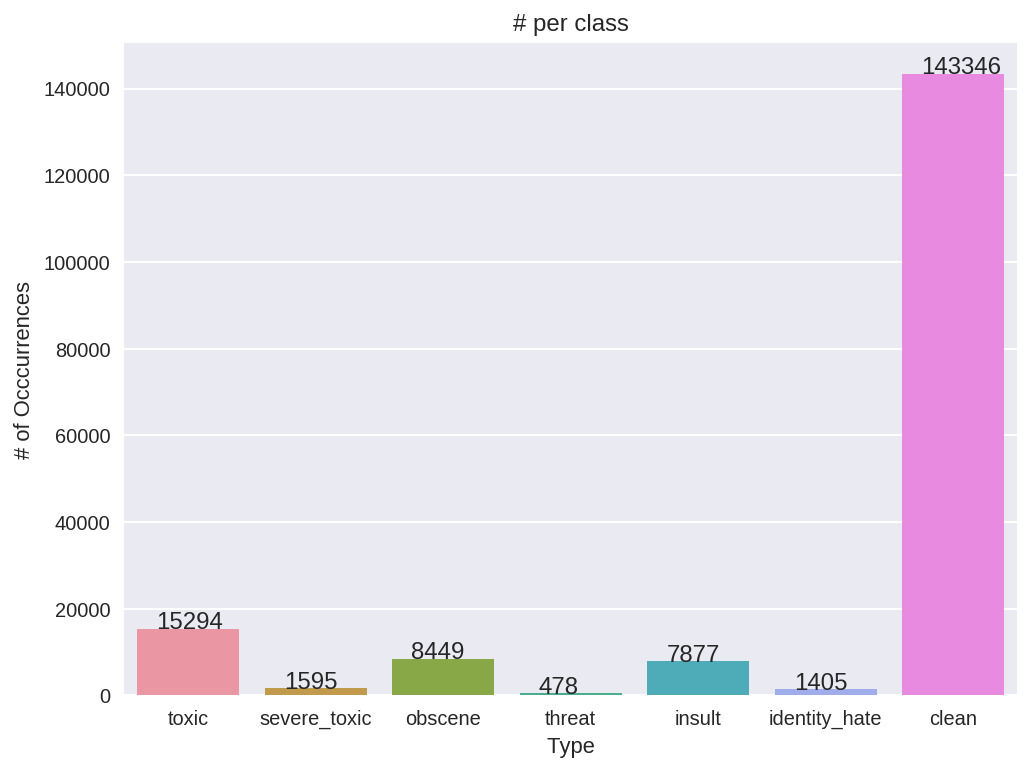

In [14]:
# 标签样本分布
stats = {}
labels = train_data.columns[2:].tolist()
for label in labels:
    stats[label] = train_data[train_data[label] == 1][label].count()
    
col_sum = train_data[labels].apply(lambda x: x.sum(), axis=1)
stats['clean'] = (col_sum == 0).sum()
x = list(stats.keys())
y = list(stats.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y)
plt.title('# per class')
plt.xlabel('Type')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


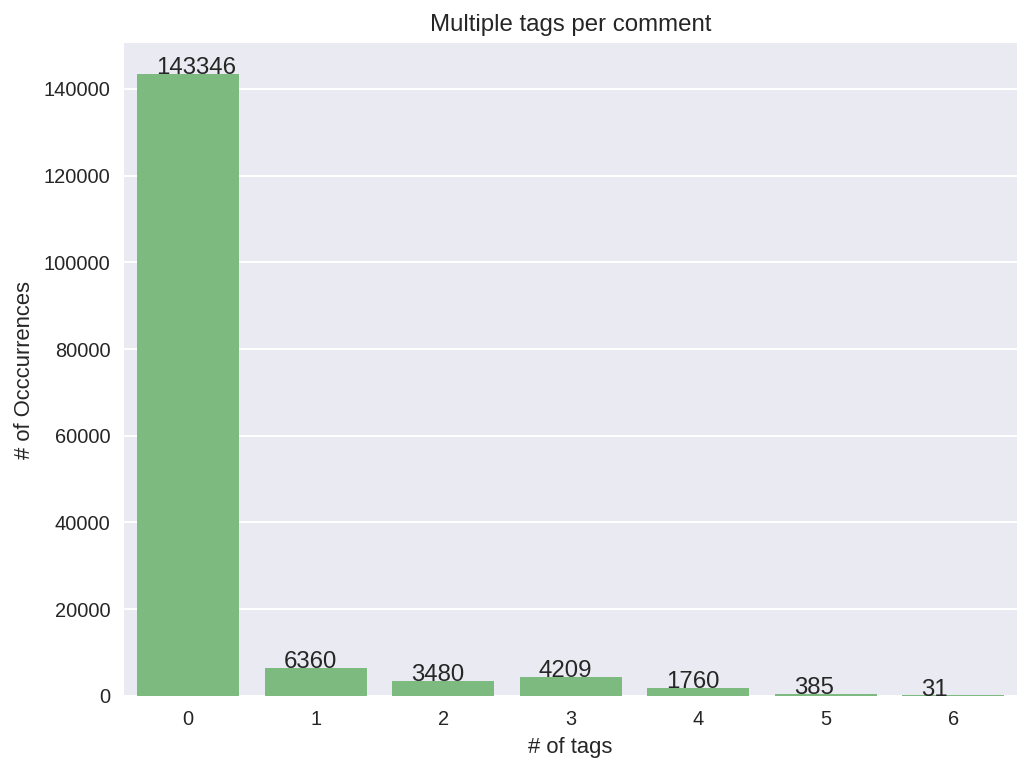

In [15]:
# 多标签分布
tag_num = {}
for count in range(len(labels)+1):
    tag_num[count] = (col_sum == count).sum()
x = list(tag_num.keys())
y = list(tag_num.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y, palette=sb.color_palette("Greens", 1))
plt.title('Multiple tags per comment')
plt.xlabel('# of tags')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


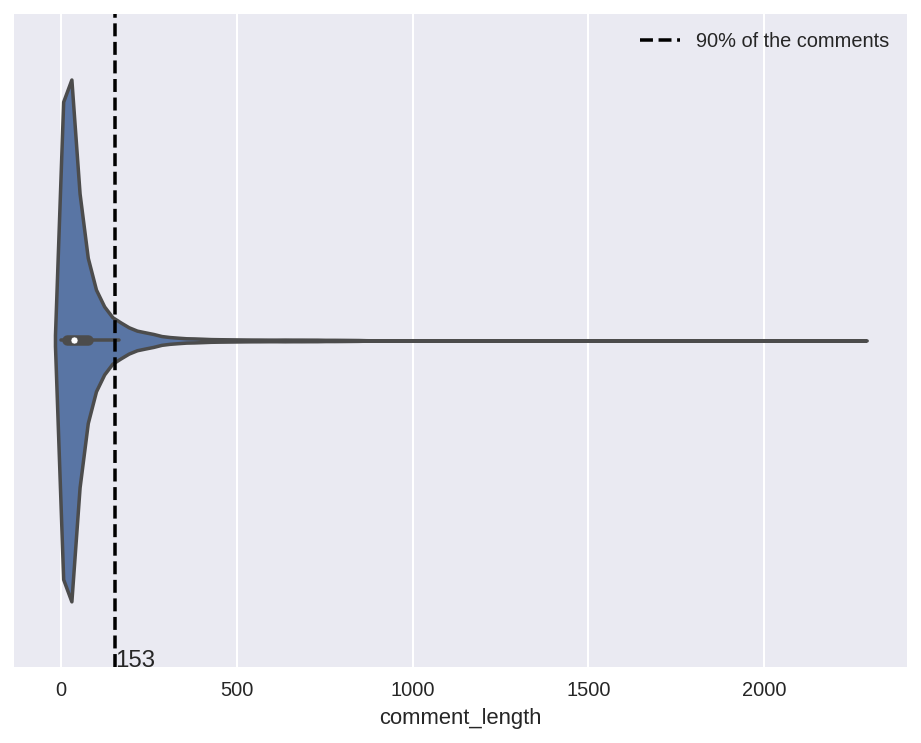

In [42]:
# 评论长度展示
comment_len = train_data['comment_text'].apply(lambda x: len(x.split(' ')))
sb.violinplot(comment_len)
plt.axvline(x=np.percentile(comment_len,90), color='k', linestyle='--', label='90% of the comments')
plt.text(np.percentile(comment_len,90), 0.5, s=int(np.percentile(comment_len,90)))
plt.xlabel('comment_length')
plt.legend()

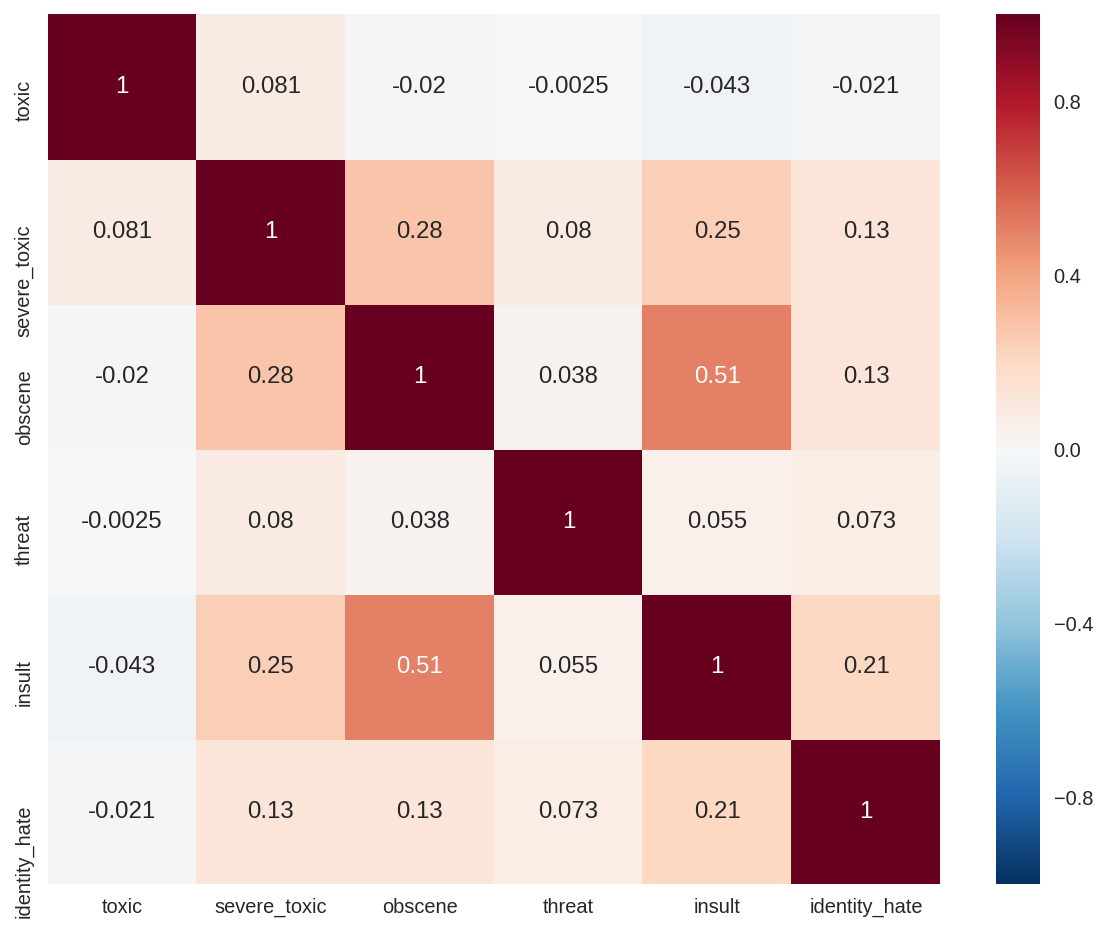

In [50]:
# 标签相关性展示
# https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
train_data['sum'] = train_data[train_data.columns[2:].tolist()].sum(axis=1)
temp = train_data[(train_data['sum']>0)].iloc[:,2:-1]
corr = temp.corr()
plt.figure(figsize=(10,8))
sb.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, 
           annot=True)
plt.show()

In [3]:
# 文本预处理 使用停用词
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
stop_words = set(stopwords.words('english'))
comments_refined = []

print('正在处理训练集文本......')
train = train.copy()
for i in tqdm(range(len(train))):
    word_seq = text_to_word_sequence(train['comment_text'][i],
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    train.loc[i, 'comment_text'] = ' '.join([word for word in word_seq 
                                             if word not in stop_words
                                            ])

print('正在处理测试集文本......')  
test = test.copy()
for i in tqdm(range(len(test))):
    word_seq = text_to_word_sequence(test['comment_text'][i],
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    test.loc[i, 'comment_text'] = ' '.join([word for word in word_seq
                                            if word not in stop_words
                                           ])

# 获取逆文档频率特征    
var = pickle.load(open('/content/gdrive/My Drive/comment/train_test.txt', 'rb'))
train = var['train']
test = var['test']
word_vectorizer = TfidfVectorizer(
                                  analyzer='word',
                                  ngram_range=(1, 2),
                                  sublinear_tf=True
#                                   max_features=100000
                                  ).fit(train['comment_text'].tolist() + 
                                        test['comment_text'].tolist())

train_features, test_features = map(lambda x: word_vectorizer.transform(tqdm(x)), 
                                    [train['comment_text'], 
                                     test['comment_text']])

  0%|          | 10/159571 [00:00<27:14, 97.60it/s]

正在处理训练集文本......


  0%|          | 6/153164 [00:00<45:21, 56.27it/s]

正在处理测试集文本......


100%|██████████| 153164/153164 [33:58<00:00, 75.12it/s]



  0%|          | 0/6 [00:00<?, ?it/s]

在toxic类上的准确率为0.9542



 17%|█▋        | 1/6 [01:18<06:34, 78.92s/it]

在severe_toxic类上的准确率为0.9902



 33%|███▎      | 2/6 [02:45<05:24, 81.22s/it]

在obscene类上的准确率为0.9756



 50%|█████     | 3/6 [04:07<04:04, 81.56s/it]

在threat类上的准确率为0.9972



 67%|██████▋   | 4/6 [05:31<02:44, 82.05s/it]

在insult类上的准确率为0.9687



 83%|████████▎ | 5/6 [06:55<01:22, 82.83s/it]

在identity_hate类上的准确率为0.9919



100%|██████████| 6/6 [08:18<00:00, 82.75s/it]


平均ACC为0.9796
平均AUC为0.9997


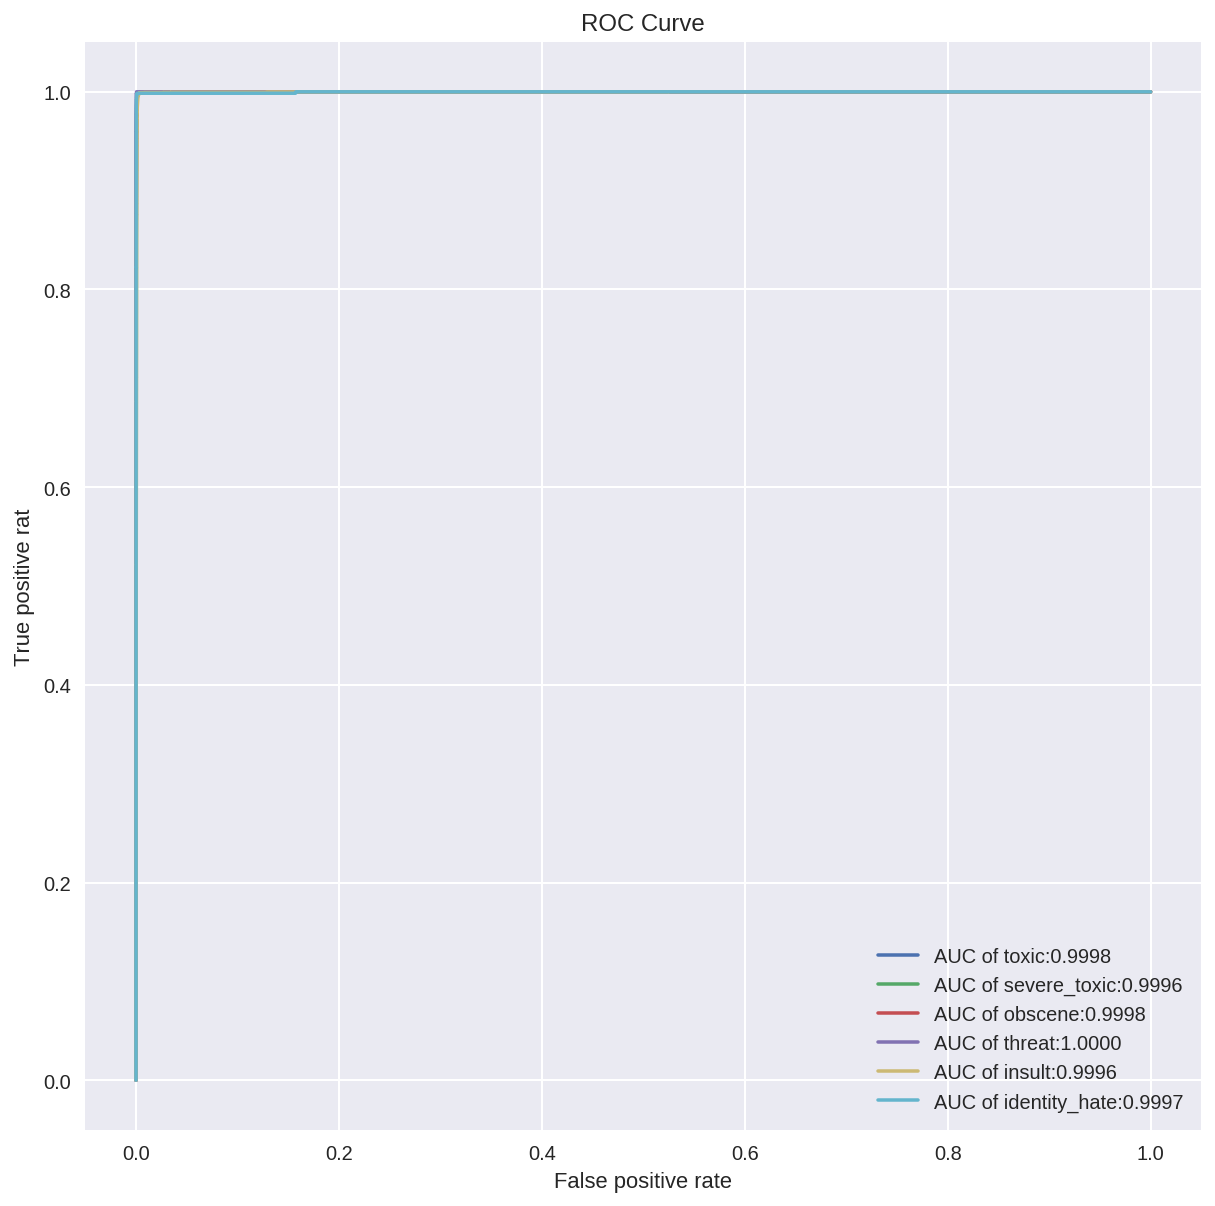

程序用时：0:08:19.084082
final score is 0.9755


In [60]:
# 逻辑回归分类器
# https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams
starttime = datetime.datetime.now()

class_dict = {}
acc_scores = []
auc_scores = []
plt.figure(figsize=(10,10))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in tqdm(labels):
    classifier = LogisticRegression(C=10,
                                    solver='sag')
    acc_scores.append(cross_val_score( classifier, 
                                       train_features, 
                                       train[label], 
                                       cv=3, 
                                       scoring='accuracy'))

    print('在{}类上的准确率为{:.4f}'.format(label, np.mean(acc_scores[-1])))
    classifier.fit(train_features, train[label])
    probs = classifier.predict_proba(train_features)[:,1]
    
    # 结果可视化
    # https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
    fpr,tpr,thres = roc_curve(train[label],probs)
    area = roc_auc_score(train[label],probs)
    auc_scores.append(area)
    plt.plot(fpr,tpr,label= 'AUC of {}:{:.4f}'.format(label, area))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rat')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    class_dict[label] = classifier
print('平均ACC为{:.4f}'.format(np.mean(acc_scores)))
print('平均AUC为{:.4f}'.format(np.mean(auc_scores)))
plt.show()

endtime = datetime.datetime.now()
print('程序用时：{}'.format(endtime - starttime))


submission = pd.DataFrame.from_dict({'id': test['id']})
for label in labels:
  submission[label] = class_dict[label].predict_proba(test_features)[:,1]
submission.to_csv('LR.csv', index=False)    
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])

print('final score is {:.4f}'.format(score))

In [4]:
print('正在加载词向量......')
fin = io.open('crawl-300d-2M.vec', 'r', encoding='utf-8')
wordvec_dict = {} #词向量字典
vec_dem = 0 #词向量维度
for line in tqdm(fin):
  tokens = line.split()
  wordvec_dict[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
  vec_dem = max(vec_dem, len(tokens[1:]))
fin.close()
print('正在保存词向量词典至wordvec_dict.txt......')
# pickle.dump({'wordvec_dict' : wordvec_dict}, 
#             open('/content/gdrive/My Drive/comment/wordvec_dict.txt', 'wb'))
print('crawl-300d-2M.vec中共有{}个词向量，每个向量的维度是{}'
      .format(len(wordvec_dict), vec_dem))

0it [00:00, ?it/s]

正在加载词向量......


1999996it [03:18, 10080.33it/s]

正在保存词向量词典至wordvec_dict.txt......
crawl-300d-2M.vec中共有1999996个词向量，每个向量的维度是300


In [0]:
# 加载词向量字典
# var = pickle.load(open('/content/gdrive/My Drive/comment/wordvec_dict.txt', 'rb'))
# wordvec_dict = var['wordvec_dict']
vec_dem = 300
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#---------------------------------------
# 文本预处理
train_pre, test_pre = [], []
print('训练集文本处理中......')
for line in tqdm(train['comment_text']):
    words = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    train_pre.append(' '.join([word for word in words]))
print('测试集文本处理中......')
for line in tqdm(test['comment_text']):
    words = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    test_pre.append(' '.join([word for word in words]))
#------------------------------------------------------------------    
# 分词
word_upper = 100000
tokenizer = Tokenizer(num_words=word_upper)
tokenizer.fit_on_texts(train_pre + test_pre)
token_train, token_test = map(lambda x: 
                              tokenizer.texts_to_sequences(tqdm(x)), 
                              [train_pre, test_pre])
word_index = tokenizer.word_index
print('评论中的词汇量为 {}'.format(len(word_index)))
maxlen = 200
x_train, x_test = map(lambda x: 
                      sequence.pad_sequences(tqdm(x), maxlen=maxlen), 
                      [token_train, token_test])
#----------------------------------------------------------------------
# 创建索引
em_mat = np.zeros((min(word_upper, len(word_index)), vec_dem))
for word, index in tqdm(word_index.items()):
    if index >= min(word_upper, len(word_index)):
      continue
    wordvec = wordvec_dict.get(word)
    if wordvec is not None:
        em_mat[index] = wordvec
#--------------------------------------------------------------    
# 保存变量
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[labels].values
# print('正在保存输入数据至input.txt......')
# pickle.dump({'x_train': x_train, 
#              'x_test': x_test, 
#              'em_mat': em_mat, 
#              'y_train': y_train}, 
#             open('/content/gdrive/My Drive/comment/input.txt', 'wb'))

  1%|▏         | 2238/159571 [00:00<00:07, 22376.93it/s]

训练集文本处理中......


  1%|▏         | 2177/153164 [00:00<00:06, 21767.32it/s]

测试集文本处理中......


100%|██████████| 159571/159571 [00:00<00:00, 1130898.17it/s]


评论中的词汇量为 341884


100%|██████████| 341884/341884 [00:00<00:00, 626113.32it/s]


正在保存输入数据至input.txt......


Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 38s 266us/step - loss: 0.1671 - acc: 0.9295 - val_loss: 0.0443 - val_acc: 0.9832

 ROC-AUC - epoch: 1 - score: 0.985237 

Epoch 2/10
143613/143613 [==============================] - 38s 261us/step - loss: 0.0525 - acc: 0.9813 - val_loss: 0.0420 - val_acc: 0.9839

 ROC-AUC - epoch: 2 - score: 0.987804 

Epoch 3/10
143613/143613 [==============================] - 37s 261us/step - loss: 0.0473 - acc: 0.9827 - val_loss: 0.0414 - val_acc: 0.9839

 ROC-AUC - epoch: 3 - score: 0.988697 

Epoch 4/10
143613/143613 [==============================] - 37s 260us/step - loss: 0.0450 - acc: 0.9831 - val_loss: 0.0413 - val_acc: 0.9841

 ROC-AUC - epoch: 4 - score: 0.988864 

Epoch 5/10
143613/143613 [==============================] - 37s 260us/step - loss: 0.0435 - acc: 0.9834 - val_loss: 0.0404 - val_acc: 0.9845

 ROC-AUC - epoch: 5 - score: 0.989713 

Epoch 6/10
143613/143613 [=============

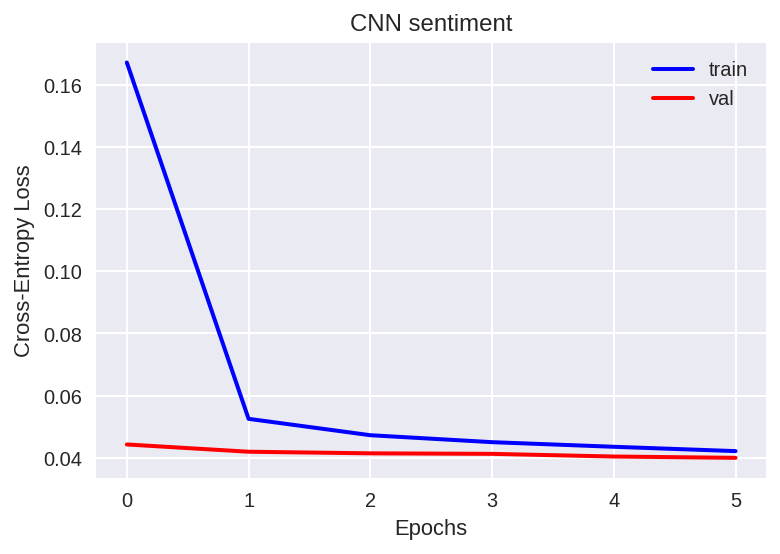

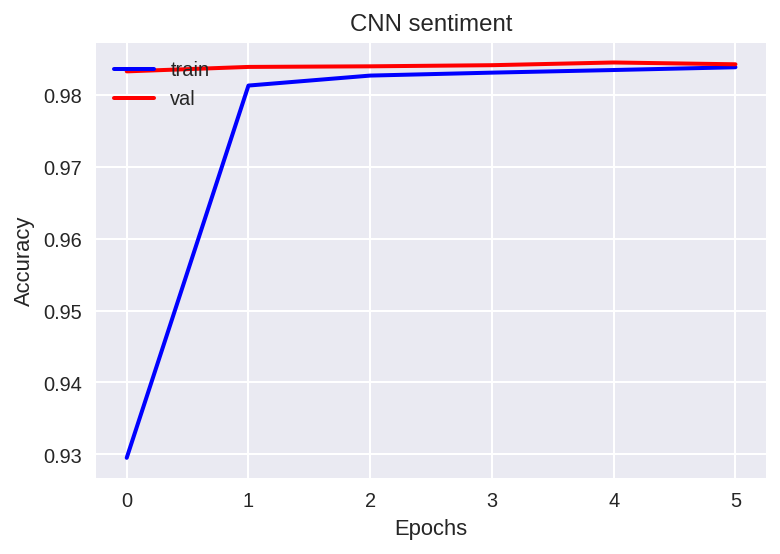

final score is 0.9835


In [9]:
# CNN模型
# https://www.kaggle.com/yekenot/textcnn-2d-convolution
# labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 
# inputs = pickle.load(open('/content/gdrive/My Drive/comment/input.txt', 'rb'))
# x_train = inputs['x_train']
# x_test = inputs['x_test']
# y_train = inputs['y_train']
# em_mat = inputs['em_mat']
#------------------------------------------------
## pure best 0.9836  #0.2 0.5  patience=5
word_upper = 100000
vec_dem = 300
maxlen = 200
batch_size = 512
epochs = 10
num_kernels = 128
kernel_sizes = [1,2,3]

#------------------------------------------------
# 定义训练期间的指标可视化
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


# 输入层
inp = Input(shape=(maxlen, ))
# 嵌入层
x = Embedding(word_upper, 
              vec_dem,  
              input_length = maxlen,
              weights=[em_mat],
              trainable=False)(inp)
# 随机丢弃
x = SpatialDropout1D(0.2)(x)

# 卷积层
conv_0 = Conv1D(num_kernels, kernel_sizes[0], 
                kernel_initializer=initializers.RandomNormal())(x)
conv_1 = Conv1D(num_kernels, kernel_sizes[1], 
                kernel_initializer=initializers.RandomNormal())(x)
conv_2 = Conv1D(num_kernels, kernel_sizes[2], 
                kernel_initializer=initializers.RandomNormal())(x)
# 激活层
ac_0 = PReLU()(conv_0)
ac_1 = PReLU()(conv_1)
ac_2 = PReLU()(conv_2)

# 归一化
# ac_0 = BatchNormalization()(ac_0)
# ac_1 = BatchNormalization()(ac_1)
# ac_2 = BatchNormalization()(ac_2)

# 池化层
maxpool_0 = GlobalMaxPooling1D()(ac_0)
maxpool_1 = GlobalMaxPooling1D()(ac_1)
maxpool_2 = GlobalMaxPooling1D()(ac_2)

# 聚合层
z = Concatenate(axis=1)([maxpool_0, 
                         maxpool_1, 
                         maxpool_2
                        ])
# 归一化
z = BatchNormalization()(z)
# 随机丢弃
z = Dropout(0.5)(z)    
# 输出层
outp = Dense(6, kernel_initializer=initializers.RandomNormal(), activation='sigmoid')(z)

model = Model(inp, outp)
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])


# model.summary()
#----------------------------------------------------------


# 划分数据
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.1, 
                                              random_state=42)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=5,
                      verbose=1)
# 训练模型
hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=[RocAuc, early], 
                 verbose=1,
                 shuffle=True,
                 class_weight='auto')
#------------------------------------------------------
# 训练指标可视化
# https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right') 
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
# 输出预测并计算分数
y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
# submission.to_csv('CNN.csv', index=False)
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 141s 985us/step - loss: 0.0722 - acc: 0.9753 - val_loss: 0.0509 - val_acc: 0.9811

 ROC-AUC - epoch: 1 - score: 0.982150 

Epoch 2/10
143613/143613 [==============================] - 140s 972us/step - loss: 0.0489 - acc: 0.9817 - val_loss: 0.0415 - val_acc: 0.9840

 ROC-AUC - epoch: 2 - score: 0.986200 

Epoch 3/10
143613/143613 [==============================] - 139s 971us/step - loss: 0.0454 - acc: 0.9826 - val_loss: 0.0430 - val_acc: 0.9834

 ROC-AUC - epoch: 3 - score: 0.988328 

Epoch 4/10
143613/143613 [==============================] - 140s 973us/step - loss: 0.0431 - acc: 0.9834 - val_loss: 0.0416 - val_acc: 0.9835

 ROC-AUC - epoch: 4 - score: 0.989990 

Epoch 5/10
143613/143613 [==============================] - 140s 973us/step - loss: 0.0416 - acc: 0.9838 - val_loss: 0.0381 - val_acc: 0.9847

 ROC-AUC - epoch: 5 - score: 0.990458 

Epoch 6/10
143613/143613 [========

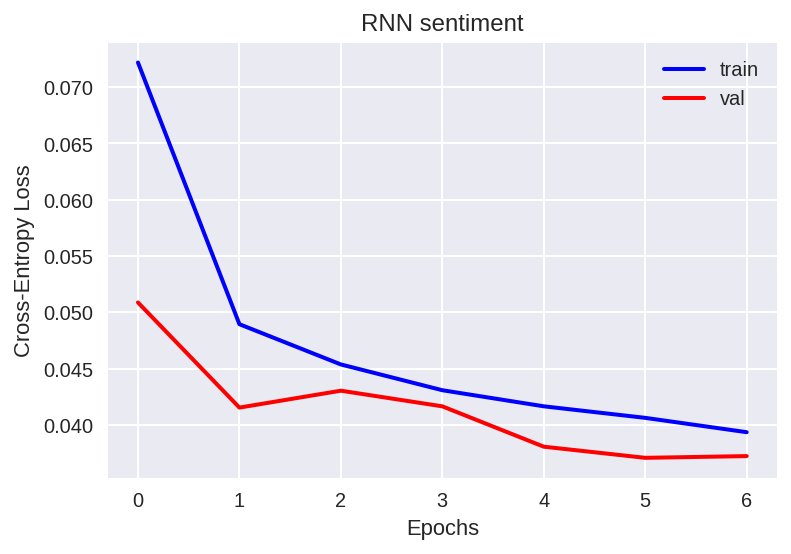

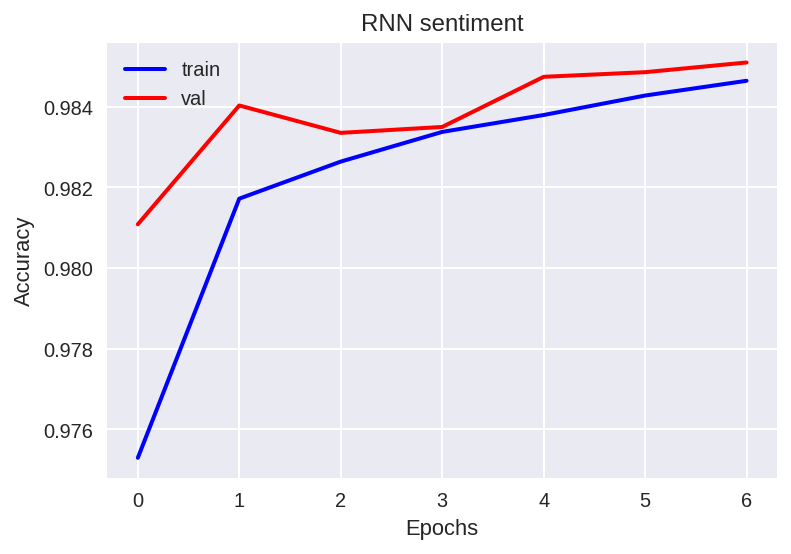

final score is 0.9850


In [62]:
# RNN模型
# https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644
word_upper = 100000
vec_dem = 300
maxlen = 200
batch_size = 512
epochs = 10

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
#——————————————————————————————————————————————————————————
inp = Input(shape=(maxlen, ))
x = Embedding(word_upper, 
              vec_dem, 
              input_length = maxlen,
              weights=[em_mat],
              trainable=False)(inp)

x = SpatialDropout1D(0.5)(x)
# RNN层
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = Concatenate(axis=1)([avg_pool,max_pool])
conc = Dropout(0.5)(conc)
outp = Dense(6, kernel_initializer=initializers.RandomNormal(), activation="sigmoid")(conc)
model = Model(inp, outp)
model.compile(loss='binary_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

# model.summary()





X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.1, 
                                              random_state=42)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=6, 
                      verbose=1)
 
hist = model.fit(
                 X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(
                     X_val, y_val
                 ),
                 callbacks=[RocAuc, early], 
                 verbose=1,
                 shuffle=True,
                 class_weight='auto')



plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


y_pred = model.predict(x_test,batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[labels] = y_pred
# submission.to_csv('CNN.csv', index=False)
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 181s 1ms/step - loss: 0.0618 - acc: 0.9784 - val_loss: 0.0410 - val_acc: 0.9841

 ROC-AUC - epoch: 1 - score: 0.987877 

Epoch 2/10
143613/143613 [==============================] - 178s 1ms/step - loss: 0.0470 - acc: 0.9822 - val_loss: 0.0396 - val_acc: 0.9844

 ROC-AUC - epoch: 2 - score: 0.989294 

Epoch 3/10
143613/143613 [==============================] - 179s 1ms/step - loss: 0.0446 - acc: 0.9830 - val_loss: 0.0393 - val_acc: 0.9845

 ROC-AUC - epoch: 3 - score: 0.989881 

Epoch 4/10
143613/143613 [==============================] - 179s 1ms/step - loss: 0.0427 - acc: 0.9835 - val_loss: 0.0387 - val_acc: 0.9847

 ROC-AUC - epoch: 4 - score: 0.989873 

Epoch 5/10
143613/143613 [==============================] - 179s 1ms/step - loss: 0.0413 - acc: 0.9841 - val_loss: 0.0387 - val_acc: 0.9845

 ROC-AUC - epoch: 5 - score: 0.990179 

Epoch 6/10
143613/143613 [==================

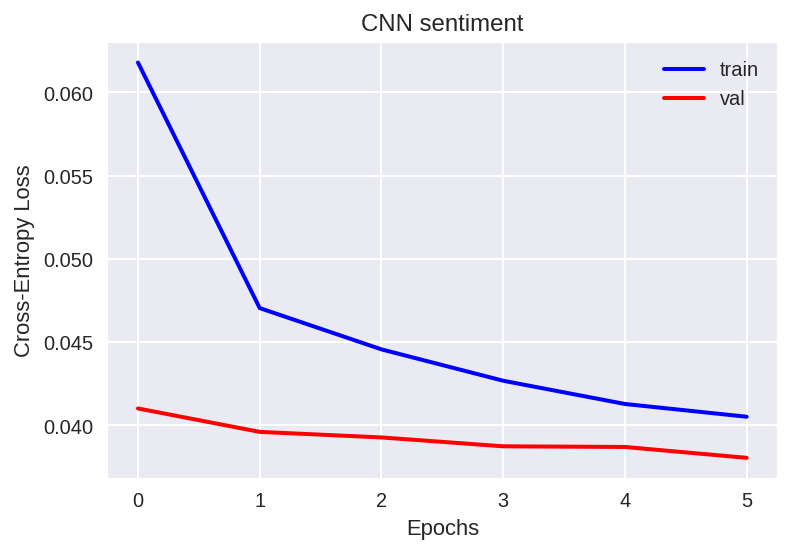

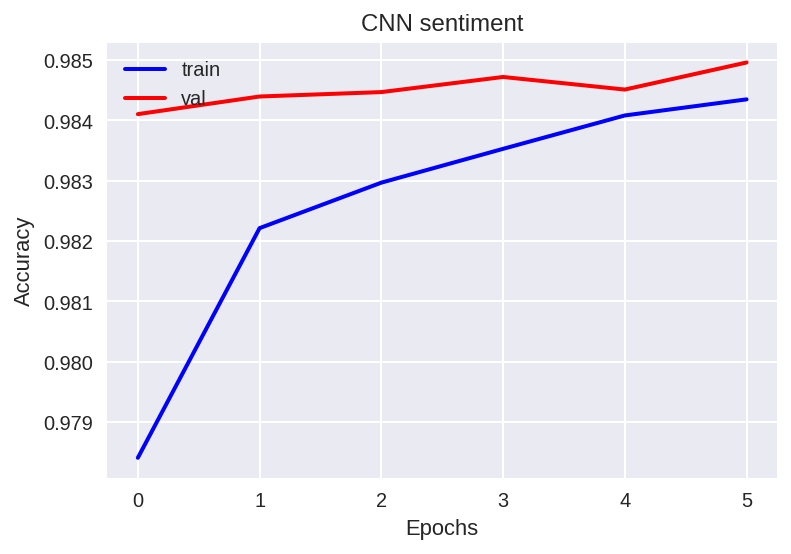

final score is 0.9844


In [63]:
# CNNRNN模型
# https://www.kaggle.com/konohayui/bi-gru-cnn-poolings
word_upper = 100000
vec_dem = 300
maxlen = 200
batch_size = 256
epochs = 10
num_kernels = 128
kernel_sizes = [1,2,3]


class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))



inp = Input(shape=(maxlen, ))
x = Embedding(word_upper, 
              vec_dem,  
              input_length = maxlen,
              weights=[em_mat],
              trainable=False)(inp)

x = SpatialDropout1D(0.5)(x)

x0 = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x0 = Conv1D(num_kernels, kernel_sizes[0], 
                kernel_initializer=initializers.RandomNormal())(x0)


x1 = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x1 = Conv1D(num_kernels, kernel_sizes[1], 
                kernel_initializer=initializers.RandomNormal())(x1)


maxpool_0 = GlobalMaxPooling1D()(x0)
maxpool_1 = GlobalMaxPooling1D()(x1)


z = Concatenate(axis=1)([maxpool_0,
                         maxpool_1
                        ])
z = Dropout(0.5)(z)   

outp = Dense(6, kernel_initializer=initializers.RandomNormal(), 
             activation='sigmoid')(z)

model = Model(inp, outp)
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])


# model.summary()
#----------------------------------------------------------



X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.1, 
                                              random_state=42)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=5,
                      verbose=1)

hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=[RocAuc, early], 
                 verbose=1,
                 shuffle=True,
                 class_weight='auto')
# #------------------------------------------------------

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right') 
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
# submission.to_csv('CNN.csv', index=False)
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))

In [0]:
# 模型可视化
# plot_model(model, to_file='CNNRNNmodel.png')

In [0]:
# 模型融合
# https://www.kaggle.com/tunguz/blend-of-blends-1
cnn4 = pd.read_csv('CNNRNN9844.csv') #Bi-GRU-CNN-Poolings 有待完善
cnn6 = pd.read_csv('CNN9836.csv') # pure cnn #已臻于完善，不稳定
gru4 = pd.read_csv('RNN9851.csv') #gru + lstm 有待加强稳定性及最高分
gru5 = pd.read_csv('RNNpool9851.csv') # rnn + pool 已初步具备稳定性
gru7 = pd.read_csv('RNNpool9852.csv')

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for label in labels:
    cnn4[label] = minmax_scale(cnn4[label])
    cnn6[label] = minmax_scale(cnn6[label])
    gru4[label] = minmax_scale(gru4[label])
    gru5[label] = minmax_scale(gru5[label])
    gru7[label] = minmax_scale(gru7[label])

blend_model = pd.DataFrame()
blend_model['id'] = cnn4['id']

In [69]:
blend_model[labels] = (
                      1*cnn4[labels] + \
                      1*cnn6[labels] + \
                      1*gru4[labels] + \
                      1*gru5[labels] + \
                      1*gru7[labels]  
                      )/5
                       
                       #0.9862

test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], blend_model.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))
blend_model.to_csv('blend9862.csv', index=False)

final score is 0.9862


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!/opt/bin/nvidia-smi

Fri Feb  8 02:15:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    70W / 149W |    121MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14439786451188719412, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16843586348736581013
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16635878298588854495
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11754923868052020251
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]